In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab_Notebooks

Mounted at /content/drive
/content/drive/MyDrive/Colab_Notebooks


In [2]:
!pip install --upgrade -q git+https://github.com/keras-team/keras-cv

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 7.2 MB/s eta 0:00:00


In [3]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

albumentations==1.3.1 is successfully installed


In [4]:
! pip install --upgrade tensorflow_datasets

In [5]:
import numpy as np
import pandas as pd
import cv2

import random
import os

import tensorflow as tf
import keras
import keras_cv
import numpy as np
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from functools import partial
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)

Using TensorFlow backend


In [6]:
default_path = os.getcwd()
train_source_df = pd.read_csv(os.path.join(default_path, "train_source.csv"))
train_target_df = pd.read_csv(os.path.join(default_path, "train_target.csv"))
val_source_df = pd.read_csv(os.path.join(default_path, "val_source.csv"))
test_df = pd.read_csv(os.path.join(default_path, "test.csv"))
submission = pd.read_csv(os.path.join(default_path, "sample_submission.csv"))

train_images_directory = os.path.join(default_path, "train_source_image")
val_images_directory = os.path.join(default_path, "val_source_image")
train_gt_directory = os.path.join(default_path, "train_source_gt")
val_gt_directory = os.path.join(default_path, "val_source_gt")

In [87]:
# Image Config
HEIGHT = 480
WIDTH = 480
NUM_CLASSES = 13

# Augmentation Config
ROTATION_FACTOR = (-0.2, 0.2)

# Training Config
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 1e-4
AUTOTUNE = tf.data.AUTOTUNE

In [8]:
train_image_paths =[path for path in train_source_df["img_path"].values]
train_label_paths = [path for path in train_source_df["gt_path"].values]
val_image_paths = [path for path in val_source_df["img_path"].values]
val_label_paths = [path for path in val_source_df["gt_path"].values]

train_image_paths = tf.convert_to_tensor(train_image_paths)
train_label_paths = tf.convert_to_tensor(train_label_paths)
val_image_paths = tf.convert_to_tensor(val_image_paths)
val_label_paths = tf.convert_to_tensor(val_label_paths)

In [129]:
train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_label_paths))
val_ds = tf.data.Dataset.from_tensor_slices((val_image_paths, val_label_paths))

In [89]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (HEIGHT, WIDTH))
    return image

def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.clip_by_value(mask, 0, 12)
    mask = tf.image.resize(mask, (HEIGHT, WIDTH), method='nearest')
    return mask

def load_dataset(image_path, mask_path):
    # Read Image
    image = load_image(image_path)
    mask = load_mask(mask_path)
    return {"images": tf.cast(image, tf.float32), "segmentation_masks": mask}

In [90]:
rescale_images_and_correct_masks = lambda inputs: {
    "images": tf.cast(inputs["images"] / 255., dtype=tf.float32),
    "segmentation_masks": tf.cast(inputs["segmentation_masks"], dtype=tf.int8),
}

In [130]:
train_ds = train_ds.map(load_dataset, num_parallel_calls=AUTOTUNE).map(rescale_images_and_correct_masks, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(load_dataset, num_parallel_calls=AUTOTUNE).map(rescale_images_and_correct_masks, num_parallel_calls=AUTOTUNE)

In [13]:
def unpackage_inputs(inputs):
    images = inputs["images"]
    segmentation_masks = inputs["segmentation_masks"]
    return images, segmentation_masks

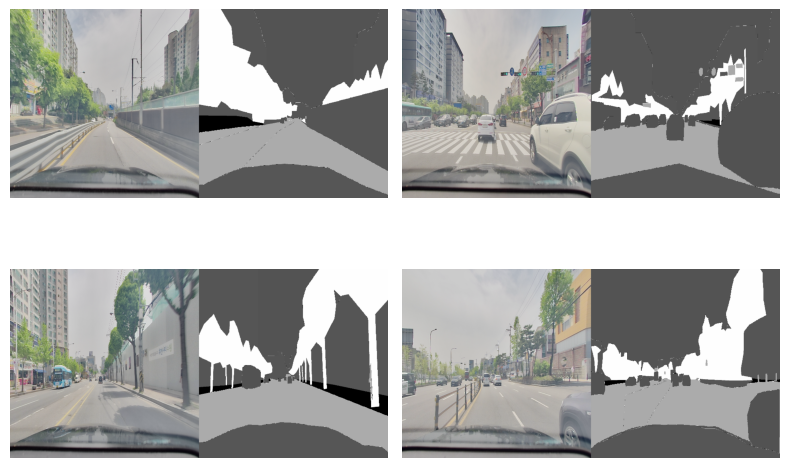

In [14]:
plot_train_ds = train_ds.map(unpackage_inputs).ragged_batch(4)
images, segmentation_masks = next(iter(plot_train_ds.take(1)))

keras_cv.visualization.plot_segmentation_mask_gallery(
    images,
    value_range=(0, 1),
    num_classes=13,
    y_true=segmentation_masks,
    y_pred=None,
    scale=4,
    rows=2,
    cols=2,
)

In [138]:
resize_fn = keras_cv.layers.Resizing(
    HEIGHT,
    WIDTH,
    interpolation = "nearest"
)

augment_fn = keras.Sequential(
    [
        keras_cv.layers.AutoContrast(value_range = (0, 1)),
        keras_cv.layers.RandAugment(value_range = (0, 1)),
        keras_cv.layers.CutMix(),
        keras_cv.layers.JitteredResize(
            target_size=(HEIGHT, WIDTH), scale_factor=(0.8, 1,25)
        )
    ]
)

In [139]:
augmented_train_ds = (
    train_ds.shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .map(augment_fn, num_parallel_calls=AUTOTUNE)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
resized_val_ds = (
    val_ds.map(resize_fn, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [142]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(
        x
    )

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Taking a batch of test inputs to measure model's progress.
test_images, test_masks = next(iter(resized_val_ds))

In [143]:
class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            pred_masks = self.model.predict(test_images)
            pred_masks = tf.math.argmax(pred_masks, axis=-1)
            pred_masks = pred_masks[..., tf.newaxis]

            # Randomly select an image from the test batch
            random_index = random.randint(0, BATCH_SIZE - 1)
            random_image = test_images[random_index]
            random_pred_mask = pred_masks[random_index]
            random_true_mask = test_masks[random_index]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
            ax[0].imshow(random_image)
            ax[0].set_title(f"Image: {epoch:03d}")

            ax[1].imshow(random_true_mask)
            ax[1].set_title(f"Ground Truth Mask: {epoch:03d}")

            ax[2].imshow(random_pred_mask)
            ax[2].set_title(
                f"Predicted Mask: {epoch:03d}",
            )

            plt.show()
            plt.close()


callbacks = [DisplayCallback(5)]

In [140]:
# 클래스 가중치
many_count_label = [0, 2, 7, 8, 11, 12]
small_count_label = [1, 3, 4, 5, 6, 9, 10]
weights = [7.0 if i in small_count_label else 0.5 for i in range(13)]

class_weight = dict(enumerate(weights))
class_weight

{0: 0.5,
 1: 7.0,
 2: 0.5,
 3: 7.0,
 4: 7.0,
 5: 7.0,
 6: 7.0,
 7: 0.5,
 8: 0.5,
 9: 7.0,
 10: 7.0,
 11: 0.5,
 12: 0.5}

Epoch 1/10
138/138 [==============================] - ETA: 0s - loss: 1.5518 - accuracy: 0.5195

1/1 [==============================] - 1s 776ms/step


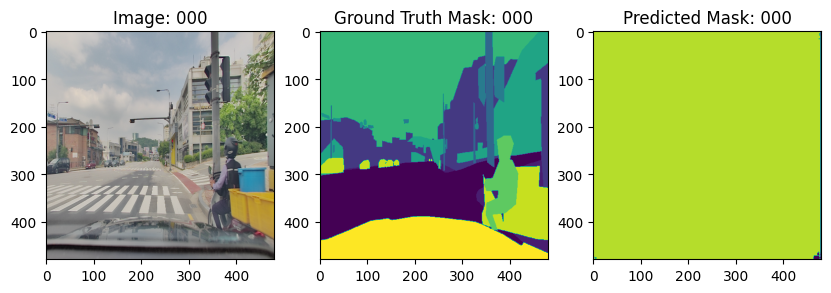

138/138 [==============================] - 439s 3s/step - loss: 1.5518 - accuracy: 0.5195 - val_loss: 4.4297 - val_accuracy: 0.2692
Epoch 2/10
138/138 [==============================] - 425s 3s/step - loss: 1.0676 - accuracy: 0.6014 - val_loss: 4.2005 - val_accuracy: 0.2700
Epoch 3/10
138/138 [==============================] - 428s 3s/step - loss: 1.0001 - accuracy: 0.6171 - val_loss: 3.8729 - val_accuracy: 0.2715
Epoch 4/10
134/138 [============================>.] - ETA: 11s - loss: 0.9352 - accuracy: 0.6382

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-144-f4de9c9e459a>", line 11, in <cell line: 11>
    history = model.fit(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 60, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.FailedPreconditionError: Graph execution error:

Detected at node ReadFile_1 defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) FAILED_PRECONDITION:  ./train_source_gt/TRAIN_SOURCE_2177.png; Transport endpoint is not connected
	 [[{{node ReadFile_1}}]]
	 [[IteratorGetNext]]
  (1) 

Custom TB Handler failed, unregistering
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-144-f4de9c9e459a>", line 11, in <cell line: 11>
    history = model.fit(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 60, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.FailedPreconditionError: Graph execution error:

Detected at node ReadFile_1 defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) FAILED_PRECONDITION:  ./train_source_gt/TRAIN_SOURCE_2177.png; Transport endpoint is not connected
	 [[{{node ReadFile_1}}]]
	 [[IteratorGetNext]]
  (1) 

In [ ]:
# Build model
model = get_model(img_size=(HEIGHT, WIDTH), num_classes=NUM_CLASSES)

model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Train the model, doing validation at the end of each epoch.
history = model.fit(
    augmented_train_ds,
    epochs=EPOCHS + 5,
    validation_data=resized_val_ds,
    callbacks=callbacks,
    class_weight=class_weight
)

In [105]:
model.save("/content/drive/MyDrive/Colab_Notebooks/u_net_like_segmentation_baseline.keras")

1/1 [==============================] - 0s 72ms/step


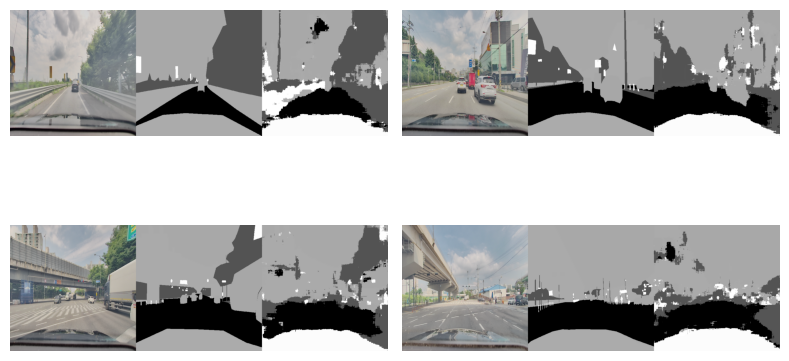

In [117]:
pred_masks = model.predict(test_images)
pred_masks = tf.math.argmax(pred_masks, axis=-1)[..., None]

keras_cv.visualization.plot_segmentation_mask_gallery(
    test_images,
    value_range=(0, 1),
    num_classes=3,
    y_true=test_masks,
    y_pred=pred_masks,
    scale=4,
    rows=2,
    cols=2,
)

1/1 [==============================] - 0s 67ms/step
(1, 480, 480, 1)


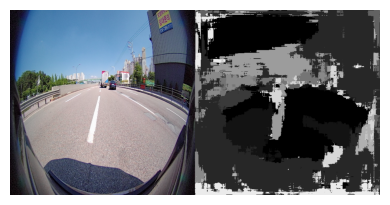

In [128]:
test_images = tf.cast(tf.expand_dims(load_image(test_df['img_path'][4]), axis=0) / 255., dtype="float32")

pred_masks = model.predict(test_images)
pred_masks = tf.expand_dims(tf.math.argmax(pred_masks, axis=-1), axis=-1)
print(pred_masks.shape)

keras_cv.visualization.plot_segmentation_mask_gallery(
    test_images,
    value_range=(0, 1),
    num_classes=13,
    y_true=pred_masks,
    scale=4,
    rows=1,
    cols=1,
)